# Look at accelerometer data 

Finding Zero velocity times by rail axis acceleration noise levels, making summary statistics for the noise levels across the whole day files.  Spot check graphs to see what works

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '-', '-', '-']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

#import CoreFunctions as cf
from skimage.restoration import denoise_wavelet

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/scratch/Recordings2/'
    imageFolder = '/scratch/Move3Dprint/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

In [4]:
Saving = False
location = folder
Titles = True
Ledgends = True

f = 0


files = ['230418 recording1.csv','230419 recording1.csv','230420 recording1.csv','230421 recording1.csv'] #,
#         '230418 recording2.csv','230419 recording2.csv','230420 recording2.csv','230421 recording2.csv']

#Smooth = cf.Smoothing(ODataSet[:,3],2) #,50)
def SmoothMoves(file):
    #    if file[-3:] =='csv':
    ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0,invalid_raise=False)
    SmoothX = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothY = denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothZ = denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothX -= np.average(SmoothX)
    SmoothY -= np.average(SmoothY)
    SmoothZ -= np.average(SmoothZ)
    MoveMatrix = np.matrix([SmoothX, SmoothY, SmoothZ])
    return MoveMatrix
    #else:
    #    pass

In [5]:
LoopFiles = 8
loops = int(len(files) / LoopFiles) 
if len(files)%LoopFiles != 0:
    loops += 1



st = ti()

Moves = []

for k in range(loops):
    if k == loops -1:
        tfiles = files[k*LoopFiles:]
    else:
        tfiles = files[k*LoopFiles:(k+1)*LoopFiles]
    #Results = Parallel(n_jobs=LoopFiles)(delayed(DeviationVelocity)(file) for file in tfiles)
    Results = Parallel(n_jobs=LoopFiles)(delayed(SmoothMoves)(file) for file in tfiles)
    #Results =[]
    #for file in tfiles:
    #    Results.append(SmoothMoves(file))
    #    print(file, (ti()-st)/60.0)
    for result in Results:
        Moves.append(result)
    print(k, (ti()-st)/60.0)
      

0 1.4675503373146057


In [6]:
  
TimeSteps = 500
StepSize = 12
PredictSize = 25
Features = 3
#Features = np.shape(Moves[0])[0]

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, s_step = 1, y_steps = 1):
    X, y = list(), list()
    Steps_to_take = int((len(sequences)-TimeSteps-PredictSize) / s_step)-1
    for j in range(Steps_to_take):
        i = j * s_step
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:end_ix+y_steps,:]
        X.append(seq_x)
        y.append(seq_y)
    print(np.shape(y))
    return np.array(X), np.array(y)

In [7]:
Sequences = []
Outputs = []
for move in Moves:
    Seq, Out = split_sequences(move.T,TimeSteps,StepSize,PredictSize)
    Sequences.append(Seq)
    Outputs.append(Out)
    

MoveSegments = []
for seq in Sequences:
    for mv in seq:
        MoveSegments.append(mv)
NextDataPoint = []
for out in Outputs:
    for pt in out:
        NextDataPoint.append(pt) #np.reshape(pt,(PredictSize,3)))

print('Move Segments ', len(MoveSegments),(ti()-st)/60.0)



(1554882, 25, 3)
(1574784, 25, 3)
(1591982, 25, 3)
(1580635, 25, 3)
Move Segments  6302283 2.954521056016286


In [8]:
np.shape(NextDataPoint[0])

(25, 3)

In [9]:
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Masking, Lambda
from keras.models import Sequential
import tensorflow as tf

2024-12-27 09:23:10.984034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-27 09:23:11.384052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-27 09:23:11.488490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 09:23:12.352582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
class LSTM_Autoencoder:
  def __init__(self, optimizer='adam', loss='mse'):
    self.optimizer = optimizer
    self.loss = loss
    self.n_features = Features
    self.timesteps = TimeSteps
    
  def build_model(self):
    timesteps = self.timesteps
    n_features = self.n_features
    model = Sequential()
    
    # Padding
    #model.add(Masking(mask_value=0.0, input_shape=(timesteps, n_features)))

    # Encoder
    model.add(LSTM(timesteps, activation='relu', input_shape=(TimeSteps, Features), return_sequences=True))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(LSTM(12, activation='relu'))
    model.add(RepeatVector(timesteps))
    
    # Decoder
    model.add(LSTM(timesteps, activation='relu', return_sequences=True))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Lambda(lambda x: x[:, -PredictSize:, :])) #Select last N from output  
    model.add(TimeDistributed(Dense( self.n_features, activation='softmax')))
    
    model.compile(optimizer=self.optimizer, loss=self.loss, metrics=['accuracy'])
    model.summary()
    self.model = model
    
  def simple_model(self):
    
    # define model
    model = Sequential()
    model.add(LSTM(250, input_shape=(TimeSteps, Features), return_sequences=True))
    #model.add(RepeatVector(TimeSteps))
    #model.add(RepeatVector(PredictSize))
    
    #model.add(LSTM(25, return_sequences=True))
    
    model.add(Lambda(lambda x: x[:, -PredictSize:, :])) #Select last N from output  
    #https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras?noredirect=1&lq=1
    
    model.add(TimeDistributed(Dense( self.n_features, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    self.model = model
    
  def fit(self, X, epochs=3, batch_size=32):
    #self.timesteps = np.shape(X)[0]
    self.build_model()
    
    #input_X = np.expand_dims(X, axis=1)
    self.model.fit(X, X, epochs=epochs, batch_size=batch_size)
    
  def predict(self, X):
    #input_X = np.expand_dims(X, axis=1)
    output_X = self.model.predict(X)
    reconstruction = np.squeeze(output_X)
    return np.linalg.norm(X - reconstruction, axis=-1)
  
  def plot(self, scores, timeseries, threshold=0.95):
    sorted_scores = sorted(scores)
    threshold_score = sorted_scores[round(len(scores) * threshold)]
    
    plt.title("Reconstruction Error")
    plt.plot(scores)
    plt.plot([threshold_score]*len(scores), c='r')
    plt.show()
    
    anomalous = np.where(scores > threshold_score)
    normal = np.where(scores <= threshold_score)
    
    plt.title("Anomalies")
    plt.scatter(normal, timeseries[normal][:,-1], s=3)
    plt.scatter(anomalous, timeseries[anomalous][:,-1], s=5, c='r')
    plt.show()

In [11]:
lstm_autoencoder2 = LSTM_Autoencoder(optimizer='adam', loss='mse')

lstm_autoencoder2.build_model()
#lstm_autoencoder2.simple_model()


2024-12-27 09:23:30.095499: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-27 09:23:30.095587: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: hi06.sciclone.wm.edu
2024-12-27 09:23:30.095598: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: hi06.sciclone.wm.edu
2024-12-27 09:23:30.095703: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: INVALID_ARGUMENT: expected %d.%d, %d.%d.%d, or %d.%d.%d.%d form for driver version; got "1"
2024-12-27 09:23:30.095733: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 555.58.2
/sciclone/home/dchendrickson01/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 500, 500)       │     1,008,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 500, 50)        │       110,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 12)             │         3,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 500, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 500, 500)       │     1,026,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 500, 50)        │       110,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 25, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 25, 3)          │           153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,577 (8.61 MB)

 Trainable params: 2,257,577 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
Batches = 64
NumbBatches = 200

SamplesPerSet = Batches * NumbBatches

SetsNeeded = int(len(MoveSegments) / SamplesPerSet)
if  int(len(MoveSegments) / SamplesPerSet) != 0:
    SetsNeeded += 1
print(len(MoveSegments), SetsNeeded)

PercentPerSet = 1.0 / float(SetsNeeded)

PercentHoldOutForNext=0.01

MoveSegments, Input_Test, NextDataPoint, Output_test = train_test_split(MoveSegments, NextDataPoint, test_size=PercentHoldOutForNext, shuffle=True, random_state=0)

6302283 493


In [13]:
st = ti()

for i in range(SetsNeeded-1):
    PercentHoldOutForNext = 1.0 - (SamplesPerSet / len(MoveSegments))
    seq_train, seq_test, out_train, out_test = train_test_split(MoveSegments, NextDataPoint, test_size=PercentHoldOutForNext, shuffle=True, random_state=0)
    seq_train = np.asarray(seq_train)
    out_train = np.asarray(out_train)
    if i == 0:
        vb = 1
    else:
        vb = 0
    with tf.device('/GPU:0'):
        H = lstm_autoencoder2.model.fit(seq_train, out_train, epochs=2, batch_size=1024, verbose=vb)
    MoveSegments = seq_test
    NextDataPoint = out_test
    print(str(i+1)+' of ' + str(SetsNeeded), (ti()-st)/60, (((ti()-st)/(i+1) * ( SetsNeeded -1) - (ti()-st) )/60/60))

    if i%5 == 0:
        lstm_autoencoder2.model.save("LSTM_predict_large_500p25.keras")

Epoch 1/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 194s 14s/step - accuracy: 0.3297 - loss: 0.1113
Epoch 2/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 174s 13s/step - accuracy: 0.3940 - loss: 0.1113
1 of 493 6.240180961290995 51.06548112637467
2 of 493 11.970000660419464 48.877503263950345
3 of 493 17.649823971589406 47.94868857430087
4 of 493 23.209422663847604 47.19249282207754
5 of 493 28.768751446406046 46.701273425857224
6 of 493 34.415794893105826 46.46132316946983
7 of 493 40.01597680648168 46.2089256479059
8 of 493 45.692525160312655 46.07329626689354
9 of 493 51.057055898507436 45.66770003654338
10 of 493 56.485560278097786 45.376733521567445
11 of 493 61.85286984443665 45.07762183646964
12 of 493 67.19483055671056 44.796553748647376
13 of 493 72.68485139211019 44.635953635247354
14 of 493 78.21078082720439 44.505658651486264
15 of 493 83.78893273671468 44.4081343730953
16 of 493 89.3103548248609 44.28305095513662
17 of 493 94.89931254784265 44.19330734110736
18 of 493 100.65122021834055 44.17470223250213

InvalidParameterError: The 'test_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got -1.2614840989399294 instead.

In [14]:
lstm_autoencoder2.model.save("LSTM_predict_large_500p25b.keras")

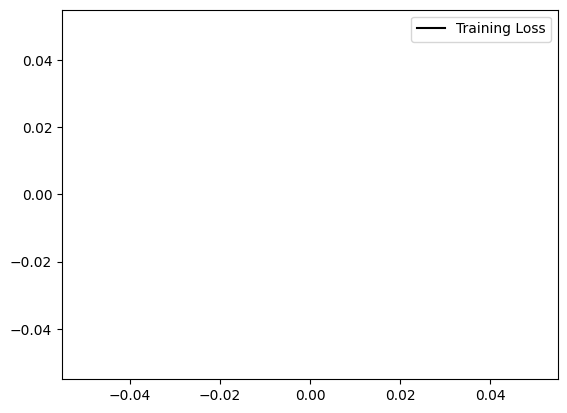

In [16]:
plt.plot(H.history["loss"], label="Training Loss")
#plt.plot(H.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [19]:
Input_Test[0]

array([[ 0.00311845,  0.01081402,  0.00319379],
       [ 0.00332033,  0.01263257,  0.00348377],
       [ 0.0037333 ,  0.0078548 ,  0.00498618],
       ...,
       [ 0.03218827,  0.01272697, -0.00209308],
       [ 0.03081046,  0.0056819 ,  0.00099249],
       [ 0.02999813,  0.00075985,  0.00289052]])

In [ ]:
output_X = lstm_autoencoder2.model.predict(Input_Test[1:5])

In [ ]:
TestResults = output_X - Output_test[1:5]

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 3), dtype=float32). Expected shape (None, 500, 3), but input has incompatible shape (32, 3)[0m

Arguments received by Sequential.call():
  • inputs=('tf.Tensor(shape=(32, 3), dtype=float32)', 'tf.Tensor(shape=(32, 3), dtype=float32)', 'tf.Tensor(shape=(32, 3), dtype=float32)', 'tf.Tensor(shape=(32, 3), dtype=float32)')
  • training=False
  • mask=('None', 'None', 'None', 'None')